# Movies Metadata
>Our project is to use data from 5000 movies from the [TMDB dataset](https://www.kaggle.com/tmdb/tmdb-movie-metadata) on Kaggle to determine:

>**What aspects of movies will correlate with higher revenue?**
>---------------------------------------------------------------------------

# Formatting the data
First we want to import our libraries, our dataset, and format the data from the csv

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from pandas.io.json import json_normalize
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [0]:
movies_df = pd.read_csv("tmdb_5000_movies.csv")

After running  `print(movies_df.isnull().any())` we found that the only columns that are null are `release_date, homepage, and tagline`. We will want to filter out the null release dates, however the other two columns should not be relevant to our project.

---


After further inspection, there are some movies with `$`0 revenue. We will also filter these out as well. After filtering out all of these, we are left with 3376 movies out of an original of 4802


In [0]:
movies_df = pd.read_csv("tmdb_5000_movies.csv")
print("Null values existance by column:")
print(movies_df.isnull().any())
print("Pre-filter Movies:", movies_df['id'].count())
movies_df = movies_df[pd.isna(movies_df['release_date']) == False]
movies_df = movies_df[movies_df['revenue'] > 0]
print("Post-filter Movies:",movies_df['id'].count())

Null values existance by column:
budget                  False
genres                  False
homepage                 True
id                      False
keywords                False
original_language       False
original_title          False
overview                 True
popularity              False
production_companies    False
production_countries    False
release_date             True
revenue                 False
runtime                  True
spoken_languages        False
status                  False
tagline                  True
title                   False
vote_average            False
vote_count              False
dtype: bool
Pre-filter Movies: 4803
Post-filter Movies: 3376


After we know which column has null value, next is to look at the type of data for each column.

In [0]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3376 entries, 0 to 4798
Data columns (total 20 columns):
budget                  3376 non-null int64
genres                  3376 non-null object
homepage                1396 non-null object
id                      3376 non-null int64
keywords                3376 non-null object
original_language       3376 non-null object
original_title          3376 non-null object
overview                3376 non-null object
popularity              3376 non-null float64
production_companies    3376 non-null object
production_countries    3376 non-null object
release_date            3376 non-null object
revenue                 3376 non-null int64
runtime                 3376 non-null float64
spoken_languages        3376 non-null object
status                  3376 non-null object
tagline                 3094 non-null object
title                   3376 non-null object
vote_average            3376 non-null float64
vote_count              3376 non-null 

**Summary:**
- Budget, id, revenue, and vote_count are integer which make sense for budget, revenue ,and vote_count but id is not. According to the use of id, we might have to convert id to categorial data. 
- Popularity, runtime, and vote_average are float type
- There are 13 column that are object type

Next, we computes several common aggregates for each numeric columns to see the overall number that we will use to analyze in the future topic. (Here we also convert id column to string first since it will not include in the aggregate of numeric columns )


In [0]:
movies_df['id'] = movies_df['id'].apply(str)
movies_df.describe()

,budget,popularity,revenue,runtime,vote_average,vote_count
count,3.376000e+03,3376.000000,3.376000e+03,3376.000000,3376.000000,3376.000000
mean,3.888424e+07,28.260492,1.170314e+08,110.382109,6.308738,944.422690
std,4.420490e+07,35.622362,1.834831e+08,21.116082,0.882279,1392.846418
min,0.000000e+00,0.019984,5.000000e+00,0.000000,0.000000,0.000000
25%,8.500000e+06,9.957286,1.535290e+07,96.000000,5.800000,160.750000
50%,2.500000e+07,19.755221,5.175184e+07,106.000000,6.300000,440.500000
75%,5.200000e+07,36.425937,1.401651e+08,121.000000,6.900000,1091.250000
max,3.800000e+08,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


**Summary:**
- the minimum data of each column still have value 0 which will need to be filter out as we use those data to analyze in the future
- Format in some column is mismatch; popularity, runtime, vote_average, and vote_count should be in number format not currency


Here we can see a few examples of the data we are working with. One thing to note is that many of the columns are JSON columns. JSON is a serialization notation that can be converted into a python `list` or `dict`. Conveniently, the introductory [kernel](https://www.kaggle.com/sohier/tmdb-format-introduction) has an example of how to handle these. We have altered it slightly to apply functions to some of the JSON columns

In [0]:
movies_df.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


In [0]:
def load_tmdb_movies(df):
    df = df.copy()
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    df['genres'] = df['genres'].apply(lambda genres_arr: [genre_dict['name'] for genre_dict in genres_arr])
    df['production_companies'] = df['production_companies'].apply(lambda prod_companies_arr: [prod_comp_dict['name'] for prod_comp_dict in prod_companies_arr])
    return df
normalized_movies = load_tmdb_movies(movies_df)

# Movies
Lets first take a look at the top 10 movies and see if we can find any similarities.


                 original_title            revenue
0                        Avatar  $2,787,965,087.00
25                      Titanic  $1,845,034,188.00
16                 The Avengers  $1,519,557,910.00
28               Jurassic World  $1,513,528,810.00
44                    Furious 7  $1,506,249,360.00
7       Avengers: Age of Ultron  $1,405,403,694.00
124                      Frozen  $1,274,219,009.00
31                   Iron Man 3  $1,215,439,994.00
546                     Minions  $1,156,730,962.00
26   Captain America: Civil War  $1,153,304,495.00


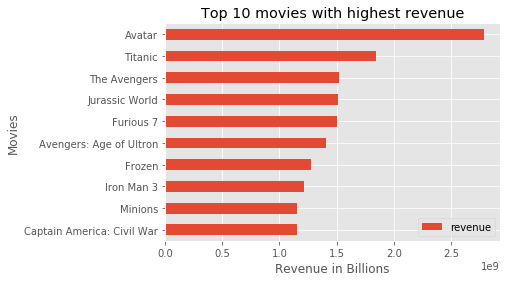

In [0]:
movies_10 = movies_df[['original_title', 'revenue']].sort_values(by=['revenue'], ascending=False)[:10]

format_movies_10 = movies_df[['original_title', 'revenue']].sort_values(by=['revenue'], ascending=False)[:10]
format_movies_10['revenue'] = format_movies_10.apply(lambda x: '${:,.2f}'.format(x['revenue']), axis=1)

print(format_movies_10)

plt.style.use('ggplot')
movies_10.sort_values('revenue',inplace=True)
movies_10.plot(x='original_title', kind='barh')
plt.xlabel('Revenue in Billions')
plt.ylabel('Movies')
plt.title('Top 10 movies with highest revenue')
plt.show()

**Initial Conclusion:** 'Avartar' has the highest revenue with $2.7 billion follow by 'Titanic'  and 'The Avengers'.

Next is to see the information of each movie in the top 10 to find the common factors that make them success. 

**Question:** What are the common factors in those top 10 movies with the highest revenue?

*Genre*

In [0]:
from tabulate import tabulate

movies_10_genre = movies_df[['original_title','revenue','genres']].sort_values(by=['revenue'], ascending=False)[:10]
print(tabulate(movies_10_genre[['original_title','genres']], headers='keys', tablefmt='psql'))


+-----+----------------------------+-----------------------------------------------------------------------------------------------------------------------------------------+
|     | original_title             | genres                                                                                                                                  |
|-----+----------------------------+-----------------------------------------------------------------------------------------------------------------------------------------|
|   0 | Avatar                     | [{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]  |
|  25 | Titanic                    | [{"id": 18, "name": "Drama"}, {"id": 10749, "name": "Romance"}, {"id": 53, "name": "Thriller"}]                                         |
|  16 | The Avengers               | [{"id": 878, "name": "Science Fiction"}, {"id": 28, "name": "Action"}, {"id": 12, "name"

**Initial Conclusion:** As you can see from the tabel, most of the movie in the top ten highest revenue are consist of repetitive genre such as Action, Adventure, Science Fiction. These group are the most frequency genre in the top ten of success movie interm of revenue. Some other following genres are Family and Animation. 

*Production Company*

In [0]:
movies_10_production_companies = movies_df[['original_title','revenue','production_companies']].sort_values(by=['revenue'], ascending=False)[:10]
print(tabulate(movies_10_production_companies[['original_title','production_companies']], headers='keys', tablefmt='psql'))

+-----+----------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|     | original_title             | production_companies                                                                                                                                                                                                                                                                                                                                                                                                                                 

**Initial Conclusion:** For production company in those top ten movie, Marvel studio has the highest number of movie with 4 out of 10. Follwed by Universal, 3, and others same 2 out of 10 includes Walt Disney, Paramount Picture, and Lightstorm Entertainment

*Production Country*

In [0]:
movies_10_production_countries = movies_df[['original_title','revenue','production_countries']].sort_values(by=['revenue'], ascending=False)[:10]
print(tabulate(movies_10_production_countries[['original_title','production_countries']], headers='keys', tablefmt='psql'))

+-----+----------------------------+------------------------------------------------------------------------------------------------------------+
|     | original_title             | production_countries                                                                                       |
|-----+----------------------------+------------------------------------------------------------------------------------------------------------|
|   0 | Avatar                     | [{"iso_3166_1": "US", "name": "United States of America"}, {"iso_3166_1": "GB", "name": "United Kingdom"}] |
|  25 | Titanic                    | [{"iso_3166_1": "US", "name": "United States of America"}]                                                 |
|  16 | The Avengers               | [{"iso_3166_1": "US", "name": "United States of America"}]                                                 |
|  28 | Jurassic World             | [{"iso_3166_1": "US", "name": "United States of America"}]                             

**Initial Conclusion:** All of movie in top ten is produced by US with some partner with other countries

*Run Time*

In [0]:
movies_10_runtime = movies_df[['original_title','revenue','runtime']].sort_values(by=['revenue'], ascending=False)[:10]
print(tabulate(movies_10_runtime[['original_title','runtime']], headers='keys', tablefmt='psql'))

+-----+----------------------------+-----------+
|     | original_title             |   runtime |
|-----+----------------------------+-----------|
|   0 | Avatar                     |       162 |
|  25 | Titanic                    |       194 |
|  16 | The Avengers               |       143 |
|  28 | Jurassic World             |       124 |
|  44 | Furious 7                  |       137 |
|   7 | Avengers: Age of Ultron    |       141 |
| 124 | Frozen                     |       102 |
|  31 | Iron Man 3                 |       130 |
| 546 | Minions                    |        91 |
|  26 | Captain America: Civil War |       147 |
+-----+----------------------------+-----------+


Let graph the run time of top 10 movie with highest revenue

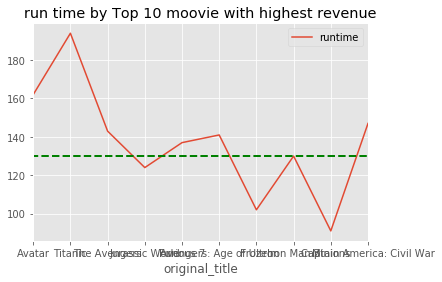

In [0]:
movies_10_runtime.plot('original_title',y='runtime',kind='line')

plt.title('run time by Top 10 moovie with highest revenue')
plt.axhline(y=130, xmin=-1, xmax=1, color='g', linestyle='--', lw=2)
plt.show()

**Initial Conclusion:** Run time data has some pattern in the top ten movie as 7 movies out of 10 has run time more than 130 minutes and most movies have the range of runtime between 130 - 160 minutes   

*Release date*

In [0]:
movies_10_release_date = movies_df[['original_title','revenue','release_date']].sort_values(by=['revenue'], ascending=False)[:10]
print(tabulate(movies_10_release_date[['original_title','release_date']], headers='keys', tablefmt='psql'))

+-----+----------------------------+----------------+
|     | original_title             | release_date   |
|-----+----------------------------+----------------|
|   0 | Avatar                     | 2009-12-10     |
|  25 | Titanic                    | 1997-11-18     |
|  16 | The Avengers               | 2012-04-25     |
|  28 | Jurassic World             | 2015-06-09     |
|  44 | Furious 7                  | 2015-04-01     |
|   7 | Avengers: Age of Ultron    | 2015-04-22     |
| 124 | Frozen                     | 2013-11-27     |
|  31 | Iron Man 3                 | 2013-04-18     |
| 546 | Minions                    | 2015-06-17     |
|  26 | Captain America: Civil War | 2016-04-27     |
+-----+----------------------------+----------------+


**Initial Conclusion:** Release might have some pattern in the top ten movie as you can see that in the release month of 4 there are 5 movovie released follow by month of 6 and 11 with 2 movie each and 1 movie on month 12. We should explore more as there are seosonality on the release date of movie or not 

**Summary:** After look at the factors in the top 10 success movie interm of revenue, we can see som hidden pattern or common factors that help the movie sucess. Next we will explore deeply in these category and see if these factor really help movie success or not.

# Movie Genres
Lets take a first look at how a movie's genre can impact the revenue. An initial problem that we can see is that each movie can have multiple genres, so how can we process a column that contains an array? We decided that it is not possible (or at least not easy) so we will be changing the column into one `boolean` column for each possible genre.

First lets make an array with all the possible genres

In [0]:
def movie_genres(movies_df):
  genres = []
  for i, movie_series in movies_df.iterrows():
      for genre in movie_series['genres']:
        if genre not in genres:
          genres.append(genre)
  return genres
genres = movie_genres(normalized_movies)
print(genres)
len(genres)
      

['Action', 'Adventure', 'Fantasy', 'Science Fiction', 'Crime', 'Drama', 'Thriller', 'Animation', 'Family', 'Western', 'Comedy', 'Romance', 'Horror', 'Mystery', 'History', 'War', 'Music', 'Documentary', 'Foreign']


19

Now lets make the columns for each genre

In [0]:
genre = None
def genre_dummies(genres):
  if genre in genres:
    return 1
  else:
    return 0


for genre in genres:
  normalized_movies['is_{0}'.format(genre)] = normalized_movies.genres.apply(genre_dummies)

Lets see how revenues differ by genre

In [0]:
average_revenues = []
for genre in genres:
  average_revenue = normalized_movies[normalized_movies['is_{0}'.format(genre)] == 1]['revenue'].mean()
  average_revenues.append((genre, average_revenue,))

sorted_revenues = sorted(average_revenues, key=lambda x: x[1], reverse=True)
sorted_revenues_formatted = [(genre, '${:,.2f}'.format(round(rev, 2)),) for genre, rev in sorted_revenues]
for tup in sorted_revenues_formatted:
  print("Genre: {0}, Average Revenue: {1}".format(*tup))

Genre: Animation, Average Revenue: $276,503,496.68
Genre: Adventure, Average Revenue: $244,209,720.82
Genre: Fantasy, Average Revenue: $233,567,521.15
Genre: Family, Average Revenue: $218,018,949.45
Genre: Science Fiction, Average Revenue: $185,795,525.62
Genre: Action, Average Revenue: $173,361,611.19
Genre: Thriller, Average Revenue: $107,664,678.07
Genre: Comedy, Average Revenue: $104,566,028.63
Genre: Mystery, Average Revenue: $101,674,338.66
Genre: War, Average Revenue: $99,331,523.86
Genre: Romance, Average Revenue: $88,811,486.00
Genre: Crime, Average Revenue: $85,737,170.74
Genre: Drama, Average Revenue: $78,396,191.21
Genre: History, Average Revenue: $75,547,611.55
Genre: Music, Average Revenue: $74,085,546.10
Genre: Horror, Average Revenue: $65,697,368.21
Genre: Western, Average Revenue: $62,166,706.74
Genre: Documentary, Average Revenue: $23,027,184.64
Genre: Foreign, Average Revenue: $2,066,358.50


Lets graph that

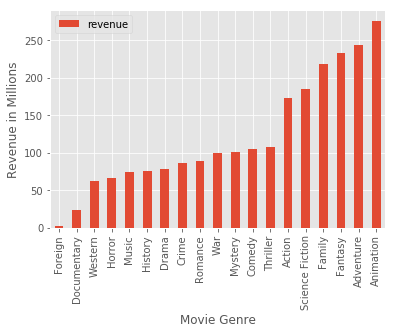

In [0]:
million = 1000000
formatted_revenues = sorted([(tup[0], tup[1] / million) for tup in sorted_revenues], key=lambda x: x[1])

revenues_df = pd.DataFrame(formatted_revenues, columns=['genre', 'revenue'])
revenues_df.plot(x='genre', y='revenue', kind='bar')
plt.ylabel('Revenue in Millions')
plt.xlabel('Movie Genre')
plt.show()

**Initial Conclusion:**
It is clear that movie genres differ greatly with respect to revenue. We can see that movies in Action, Science Fiction, Family, Fantasy, Action, Adventure, and Animation have much larger revenue than all the other genres by a wide margin. We also can see that Foreign films and Documentaries will have an extremely low revenue.

***Additional:*** we might need to see the budget data also as is the revenue is high not becuase the budget is also high beacuse the movie with high investment will have better quality and famous lead that help attract more people. 

Here is how budget differ by genre

In [0]:
average_budgets = []
for genre in genres:
  average_budget = normalized_movies[normalized_movies['is_{0}'.format(genre)] == 1]['budget'].mean()
  average_budgets.append((genre, average_budget,))

sorted_budget = sorted(average_budgets, key=lambda x: x[1], reverse=True)
sorted_budget_formatted = [(genre, '${:,.2f}'.format(round(bud, 2)),) for genre, bud in sorted_budget]
for tup in sorted_budget_formatted:
  print("Genre: {0}, Average Budget: {1}".format(*tup))

Genre: Animation, Average Budget: $79,557,178.30
Genre: Adventure, Average Budget: $75,297,583.77
Genre: Fantasy, Average Budget: $73,701,412.63
Genre: Family, Average Budget: $65,204,812.06
Genre: Science Fiction, Average Budget: $61,669,373.72
Genre: Action, Average Budget: $60,930,347.32
Genre: War, Average Budget: $40,312,678.31
Genre: Thriller, Average Budget: $39,929,015.04
Genre: Mystery, Average Budget: $38,331,838.25
Genre: History, Average Budget: $36,496,372.04
Genre: Comedy, Average Budget: $34,184,459.08
Genre: Crime, Average Budget: $33,719,198.07
Genre: Western, Average Budget: $33,154,977.07
Genre: Drama, Average Budget: $28,333,861.00
Genre: Romance, Average Budget: $26,893,100.71
Genre: Music, Average Budget: $21,988,823.02
Genre: Horror, Average Budget: $19,840,503.51
Genre: Documentary, Average Budget: $4,384,473.68
Genre: Foreign, Average Budget: $2,204,167.83


Now lets compare budget and revenue and graph them

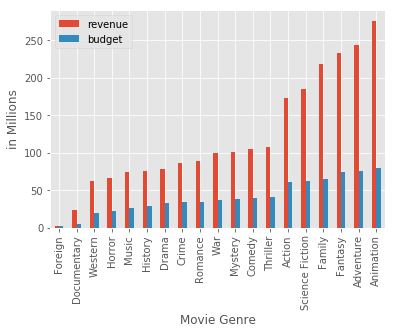

In [0]:
million = 1000000
formatted_revenues = sorted([(tup[0], tup[1] / million) for tup in sorted_revenues], key=lambda x: x[1])
formatted_budget = sorted([(tup[0], tup[1] / million) for tup in sorted_budget], key=lambda x: x[1])

revenues_df = pd.DataFrame(formatted_revenues, columns=['genre', 'revenue'])
budget_df = pd.DataFrame(formatted_budget, columns=['genre1', 'budget'])

rev_budg_df = pd.concat([revenues_df,budget_df],axis=1, join='inner')
rev_budg_fil_df = rev_budg_df[['genre', 'revenue','budget']] 

rev_budg_df.plot(x='genre',kind='bar')
plt.ylabel('in Millions')
plt.xlabel('Movie Genre')
plt.show()


**Initial Conclusion** Genre with higher revenue also have higher budget but the fraction of revenue higher is much more than the budget, therefore, revenue is effected by genre 

# Original Language

In [0]:
average_rev_by_language = normalized_movies.groupby('original_language').revenue.mean().sort_values()
print(average_rev_by_language)

original_language
is    1.100000e+01
el    1.101970e+05
vi    6.390000e+05
fa    9.000000e+05
ro    1.185783e+06
no    1.984662e+06
id    2.274881e+06
nb    4.159678e+06
it    7.068818e+06
af    9.879971e+06
pl    1.070000e+07
he    1.112585e+07
nl    1.336156e+07
ru    1.494440e+07
hi    1.572193e+07
th    1.805112e+07
pt    1.811924e+07
fr    3.115378e+07
es    3.315943e+07
de    3.769714e+07
ko    3.984585e+07
da    5.232305e+07
xx    5.526056e+07
cn    5.784027e+07
zh    8.048889e+07
ja    8.126636e+07
te    1.000000e+08
en    1.205033e+08
Name: revenue, dtype: float64


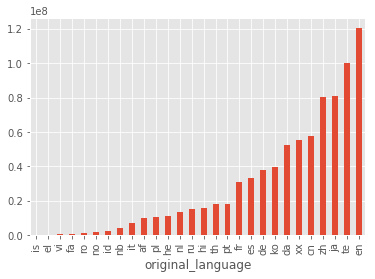

In [0]:
average_rev_by_language.plot(kind='bar', sort_columns=True)
plt.show()

**Initial Conclusion:** We can see that the revenue generation differs greatly by the original language of the film

# Correlations
Now we will look at some more data that we think could have an effect on revenue and do linear regression plots of the individual variables

**Popularity and Revenue**
------------------------------------

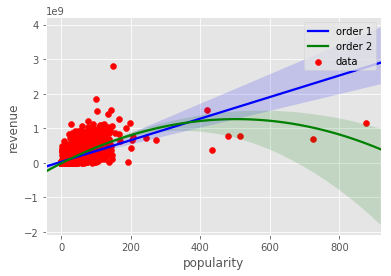

In [0]:
plt.scatter(movies_df['popularity'], movies_df['revenue'], label='data', color='red', marker='o')
sns.regplot(x='popularity', y='revenue', data=movies_df, scatter=None, color='blue', label='order 1')
sns.regplot(x='popularity', y='revenue', data=movies_df, scatter=None, order=2,color='green', label='order 2')
plt.legend(loc='upper right')
plt.show()


It looks like there is a slight correlation, but it might be because of outliers. Lets do a hex plot to see what the distribution of values is.



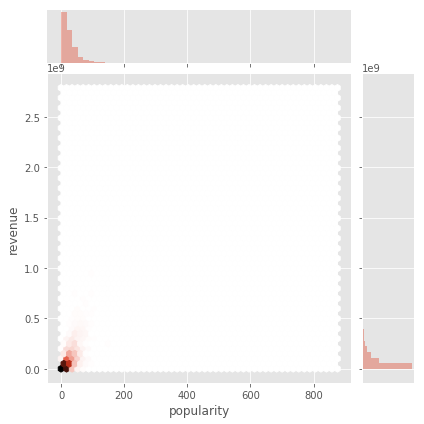

In [0]:
sns.jointplot(x="popularity", y="revenue", data=movies_df, kind="hex")

**Initial Conclusion**: 
There doesn't appear to be enough data with high popularities in order to infer anything from the popularity. A small number of movies which have way higher popularity values are also among the average range of popularity


**Budget and Revenue**
------------------------------------
Earlier we saw a bar chart with budget and revenue. Lets now plot the correlation to see how that looks

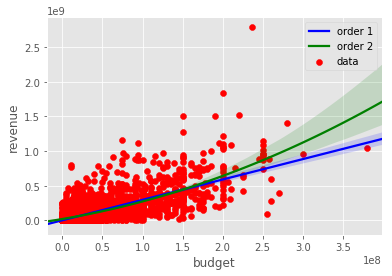

In [0]:
plt.scatter(movies_df['budget'], movies_df['revenue'], label='data', color='red', marker='o')
sns.regplot(x='budget', y='revenue', data=movies_df, scatter=None, color='blue', label='order 1')
sns.regplot(x='budget', y='revenue', data=movies_df, scatter=None, order=2,color='green', label='order 2')
plt.legend(loc='upper right')
plt.show()


**Initial Conclusion:**  This plot supports what we saw earlier that budgets do appear to be correlated with revenue.

**Runtime and Revenue**
------------------------------------

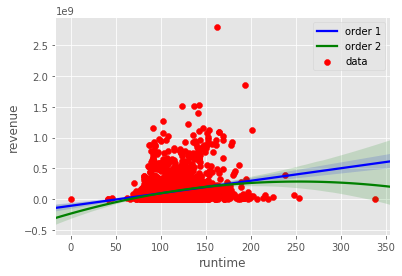

In [0]:
plt.scatter(movies_df['runtime'], movies_df['revenue'], label='data', color='red', marker='o')
sns.regplot(x='runtime', y='revenue', data=movies_df, scatter=None, color='blue', label='order 1')
sns.regplot(x='runtime', y='revenue', data=movies_df, scatter=None, order=2,color='green', label='order 2')
plt.legend(loc='upper right')
plt.show()

**Initial Conclusion:** The correlation between revenue and runtime looks stronger than other attributes, which suggests that for top movies, runtime should not be too short. It also makes some sense logically since some phenomenal blockbusters such as Avatar usually need longer runtime to build a impressive story line.

**Vote Average and Revenue**
------------------------------------------------------


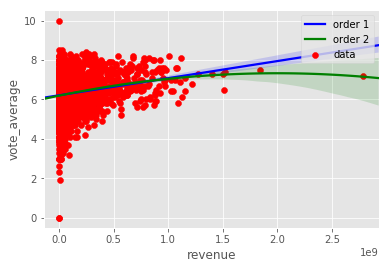

In [0]:
plt.scatter(movies_df['revenue'], movies_df['vote_average'], label='data', color='red', marker='o')
sns.regplot(x='revenue', y='vote_average', data=movies_df, scatter=None, color='blue', label='order 1')
sns.regplot(x='revenue', y='vote_average', data=movies_df, scatter=None, order=2,color='green', label='order 2')
plt.legend(loc='upper right')
plt.show()

**Initial Conclusion:** The above plot shows that there is a relative positive, but not a very strong, correlation between rate and revenue. Although the revenue column has quite a number of '0' value records, so it's possible that the correlation result has been affected. But the analysis also clearly showed that most of movies with relative high revenue received average or above average rates.

# Seasonality
Will the time of year relate to the amount of revenue generated by a film? Lets graph a few years and see if there are any patterns.

Code Source: [Plotting seasonality](http://atedstone.github.io/pandas-plot-seasons-time-series/)

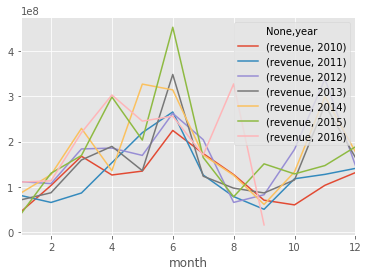

In [0]:
movies_by_month = normalized_movies.copy()
movies_by_month.index = pd.DatetimeIndex(movies_by_month['release_date'])
movies_by_month = movies_by_month.loc['2010':'2016']
movies_by_month['month'] = movies_by_month.index.month
movies_by_month['year'] = movies_by_month.index.year
piv = pd.pivot_table(movies_by_month, index=['month'], columns=['year'], values=['revenue'])
piv.plot()

**Initial Conclusion:**
It does appear that movie revenues tends to be seasonal. We can see an uptick in April, June and November.

# Production Companies
Do some production companies generate more revenue on average? Lets do a similar analysis as we did with Movie Genres to see if we can see any trends

Lets first see how many production companies there are. Here we made a function to retrieve the top "x" production companies from the dataframe. Lets just grab all of them though.

In [0]:
def top_movie_prod_companies(movies_df, number):
  companies = []
  for i, movie_series in movies_df.sort_values("revenue", ascending=False).head(number).iterrows():
      for prod_company in movie_series['production_companies']:
        if prod_company not in companies:
          companies.append(prod_company)
  return companies


top_prod_companies = top_movie_prod_companies(normalized_movies, 4000)

print(len(top_prod_companies))


3736


Wow, 3736 companies, thats a lot of categorical data. We should still be able to make those boolean columns like we did previously with genres

In [0]:
for prod_company in top_prod_companies:
  normalized_movies['prod_by_{0}'.format(prod_company)] = normalized_movies.production_companies.apply(lambda production_companies: prod_company in production_companies)

Now we will create a function to select data about all the production companies that have produced a minimum number of movies

Lets grab the production companies that have made at least 10 movies

In [0]:
def top_revenue_producing_companies(dataframe, companies_arr, num_movies_produced):
  average_prod_company_revenues = []
  avg_prod_company = []
  for prod_company in companies_arr:
    prod_company_rows = dataframe[(dataframe['prod_by_{0}'.format(prod_company)])]
    if prod_company_rows.id.count() >= num_movies_produced:
      average_revenue = prod_company_rows.revenue.mean()
      movies_count = prod_company_rows.id.count()
      average_prod_company_revenues.append((prod_company, average_revenue, movies_count,))
  return average_prod_company_revenues

revenue_data = top_revenue_producing_companies(normalized_movies, top_prod_companies, 10)

sorted_revenues = sorted(revenue_data, key=lambda x: x[1], reverse=True)
sorted_revenues_formatted = [(prod_company, '${:,.2f}'.format(round(rev, 2)), count) for prod_company, rev, count in sorted_revenues]


Now lets see the top 10 and bottom 10 production companies by revenue generation of that list

In [0]:
min_10 = sorted_revenues[-10:]
min_10_formatted = sorted_revenues_formatted[-10:]
max_10 = sorted_revenues[0:10]
max_10_formatted = sorted_revenues_formatted[0:10]

print("Top 10 Revenue Producing Film Companies that have made at least 10 films")
for tup in max_10_formatted:
  print("Production Company: {0}, Average Revenue: {1}, Number of Movies: {2}".format(*tup))
  
print()
print("Bottom 10 Revenue Producing Film Companies that have made at least 10 films")
for tup in min_10_formatted:
  print("Production Company: {0}, Average Revenue: {1}, Number of Movies: {2}".format(*tup))

Top 10 Revenue Producing Film Companies that have made at least 10 films
Production Company: Marvel Studios, Average Revenue: $779,876,975.38, Number of Movies: 13
Production Company: WingNut Films, Average Revenue: $643,763,863.82, Number of Movies: 11
Production Company: Pixar Animation Studios, Average Revenue: $613,112,049.25, Number of Movies: 16
Production Company: Revolution Sun Studios, Average Revenue: $517,989,606.06, Number of Movies: 16
Production Company: DC Entertainment, Average Revenue: $506,160,449.10, Number of Movies: 10
Production Company: Lucasfilm, Average Revenue: $471,909,764.29, Number of Movies: 14
Production Company: Dentsu, Average Revenue: $444,760,118.42, Number of Movies: 12
Production Company: Twentieth Century Fox Animation, Average Revenue: $442,413,826.45, Number of Movies: 11
Production Company: DreamWorks Animation, Average Revenue: $411,322,963.26, Number of Movies: 31
Production Company: Jerry Bruckheimer Films, Average Revenue: $379,654,093.11, N

Lets plot what those look like next to each other

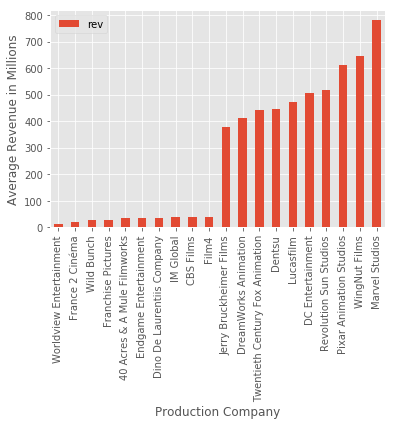

In [0]:
million = 1000000
formatted_revenues = sorted([(tup[0], tup[1] / million) for tup in min_10 + max_10], key=lambda x: x[1])

revenues_dataframe = pd.DataFrame(formatted_revenues, columns=['prod_company', 'rev'])
revenues_dataframe.plot(x='prod_company', y='rev', kind='bar')
plt.ylabel('Average Revenue in Millions')
plt.xlabel('Production Company')
plt.show()

**Initial Conclusion**: It is clear that production company have a very large effect on revenue. We can see that the difference between the top film production companies and the bottom is extremely wide.

> Indented block



# Conclusion
We have identified a list of variables that we think have a correlation with revenue generation. Our next steps are to test this further by building multivariable regression models and potentially a predictive model in the next assignment. We look forward to going into more depth on the analysis we have done in this assignment.

# Machine Learning

Preprocessing
------------------------------------
First we make sure all rows have a positive budget, then we drop all the columns that will not be used in our learning. We also drop one column from each of the "dummy" columns we made previously and convert the release_date to an ordinal (e.g. timestamp)

In [0]:
normalized_movies = normalized_movies[normalized_movies['budget'] > 0]
normalized_movies = normalized_movies.drop(['genres', 'homepage', 'id', 'keywords', 'original_title', 'overview', 'production_companies', 'production_countries', 'spoken_languages', 'status', 'tagline', 'title', 'prod_by_C.R.G. International', 'is_Foreign'], axis=1)
normalized_movies['release_date'] = normalized_movies.release_date.apply(lambda x: x.toordinal())
normalized_movies = pd.get_dummies(normalized_movies, ['original_language'], drop_first=True)

## Correlation

Before jumping to model, Lets see correlation between numeric variable to see which variable is relate to each other and how the relationship between those variables.

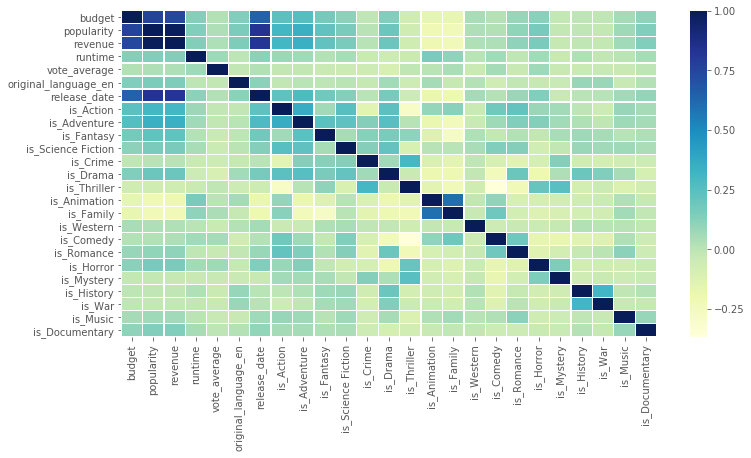

In [0]:
normalized_movies_corr = normalized_movies[['budget', 'popularity','revenue','runtime','vote_average','original_language_en','release_date','is_Action', 'is_Adventure', 'is_Fantasy', 'is_Science Fiction', 'is_Crime', 'is_Drama', 'is_Thriller', 'is_Animation', 'is_Family', 'is_Western', 'is_Comedy', 'is_Romance', 'is_Horror', 'is_Mystery', 'is_History', 'is_War', 'is_Music', 'is_Documentary']]

plt.figure(figsize=(12, 6))
corr = normalized_movies_corr.apply(lambda x: pd.factorize(x)[0]).corr()
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
                 linewidths=.2, cmap="YlGnBu")

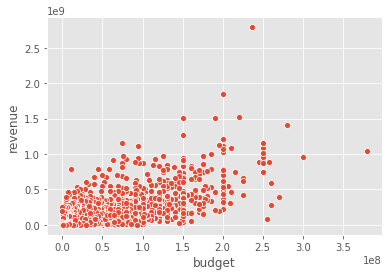

In [0]:
sns.scatterplot(x='budget',y='revenue',data=normalized_movies)

**Initial conclusion:** as the release date, genre in action, adventure ,and drama, and runtime have the most positive correlation with revenue respectively. However some type of genre has negative relationship with reveunue which is animation and family. We can conclude that release date, runtime, and the specific type of genre has somwhat effect the revenue the movie going to get.

## Regression

In [0]:
normalized_movies.head()

,budget,popularity,release_date,revenue,runtime,vote_average,vote_count,is_Action,is_Adventure,is_Fantasy,...,original_language_no,original_language_pl,original_language_pt,original_language_ro,original_language_ru,original_language_te,original_language_th,original_language_vi,original_language_xx,original_language_zh
0,237000000,150.437577,733751,2787965087,162.0,7.2,11800,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,300000000,139.082615,732815,961000000,169.0,6.9,4500,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,245000000,107.376788,735897,880674609,148.0,6.3,4466,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,250000000,112.312950,734700,1084939099,165.0,7.6,9106,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,260000000,43.926995,734569,284139100,132.0,6.1,2124,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [0]:
X = normalized_movies.drop('revenue', axis=1)
X.shape

(3229, 3785)

In [0]:
y = normalized_movies['revenue']
y.shape

(3229,)

In [0]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=833)

In [0]:
from sklearn.linear_model import LinearRegression  
model = LinearRegression()   

In [0]:
model.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [0]:
y_model = model.predict(Xtest)

In [0]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(ytest, y_model)

120875527.23247091

We have a mean absolute error of 121 million. Lets see if we can improve on that with a Logistic Model

In [0]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression(C=10, fit_intercept=False)
model.fit(Xtrain, ytrain)
y_model = model.predict(Xtest)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [0]:
mean_absolute_error(ytest, y_model)

83943473.00515996

**Initial Conclusion: ** we built two different regression models and tested them. The Logistic Regression model performs significantly better with a mean error of 84 million dollars compared to a mean error of 121 million dollars with the Linear Regression model. 

## **Classification**

In addition to the previous analysis, we also would like to further analyze profit to better evaluate the performance of movies. Also, we want to establish classification and machine learning prediction model to see if we can provide hints to predict movie profit in the future by using logistic regression.
 

We firstly added a new column called "profit", then added other features which we would like to analyze including budget, popularity, revenue, runtine, and vote_average.

In [0]:
def profit (row):
  if row['revenue'] > row['budget'] :
    return '1'
  return '0'

In [0]:
normalized_movies['profit'] = normalized_movies.apply(lambda row: profit(row), axis=1)
normalized_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3229 entries, 0 to 4798
Columns: 3787 entries, budget to profit
dtypes: bool(3735), float64(3), int64(22), object(1), uint8(26)
memory usage: 12.2+ MB


In [0]:
normalized_movies_class = normalized_movies[['budget', 'popularity','revenue','runtime','vote_average', 'profit','original_language_en','release_date','is_Action', 'is_Adventure', 'is_Fantasy', 'is_Science Fiction', 'is_Crime', 'is_Drama', 'is_Thriller', 'is_Animation', 'is_Family', 'is_Western', 'is_Comedy', 'is_Romance', 'is_Horror', 'is_Mystery', 'is_History', 'is_War', 'is_Music', 'is_Documentary']].copy()


We can also see the relationship between two variables by plotting each pair between two variable.

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


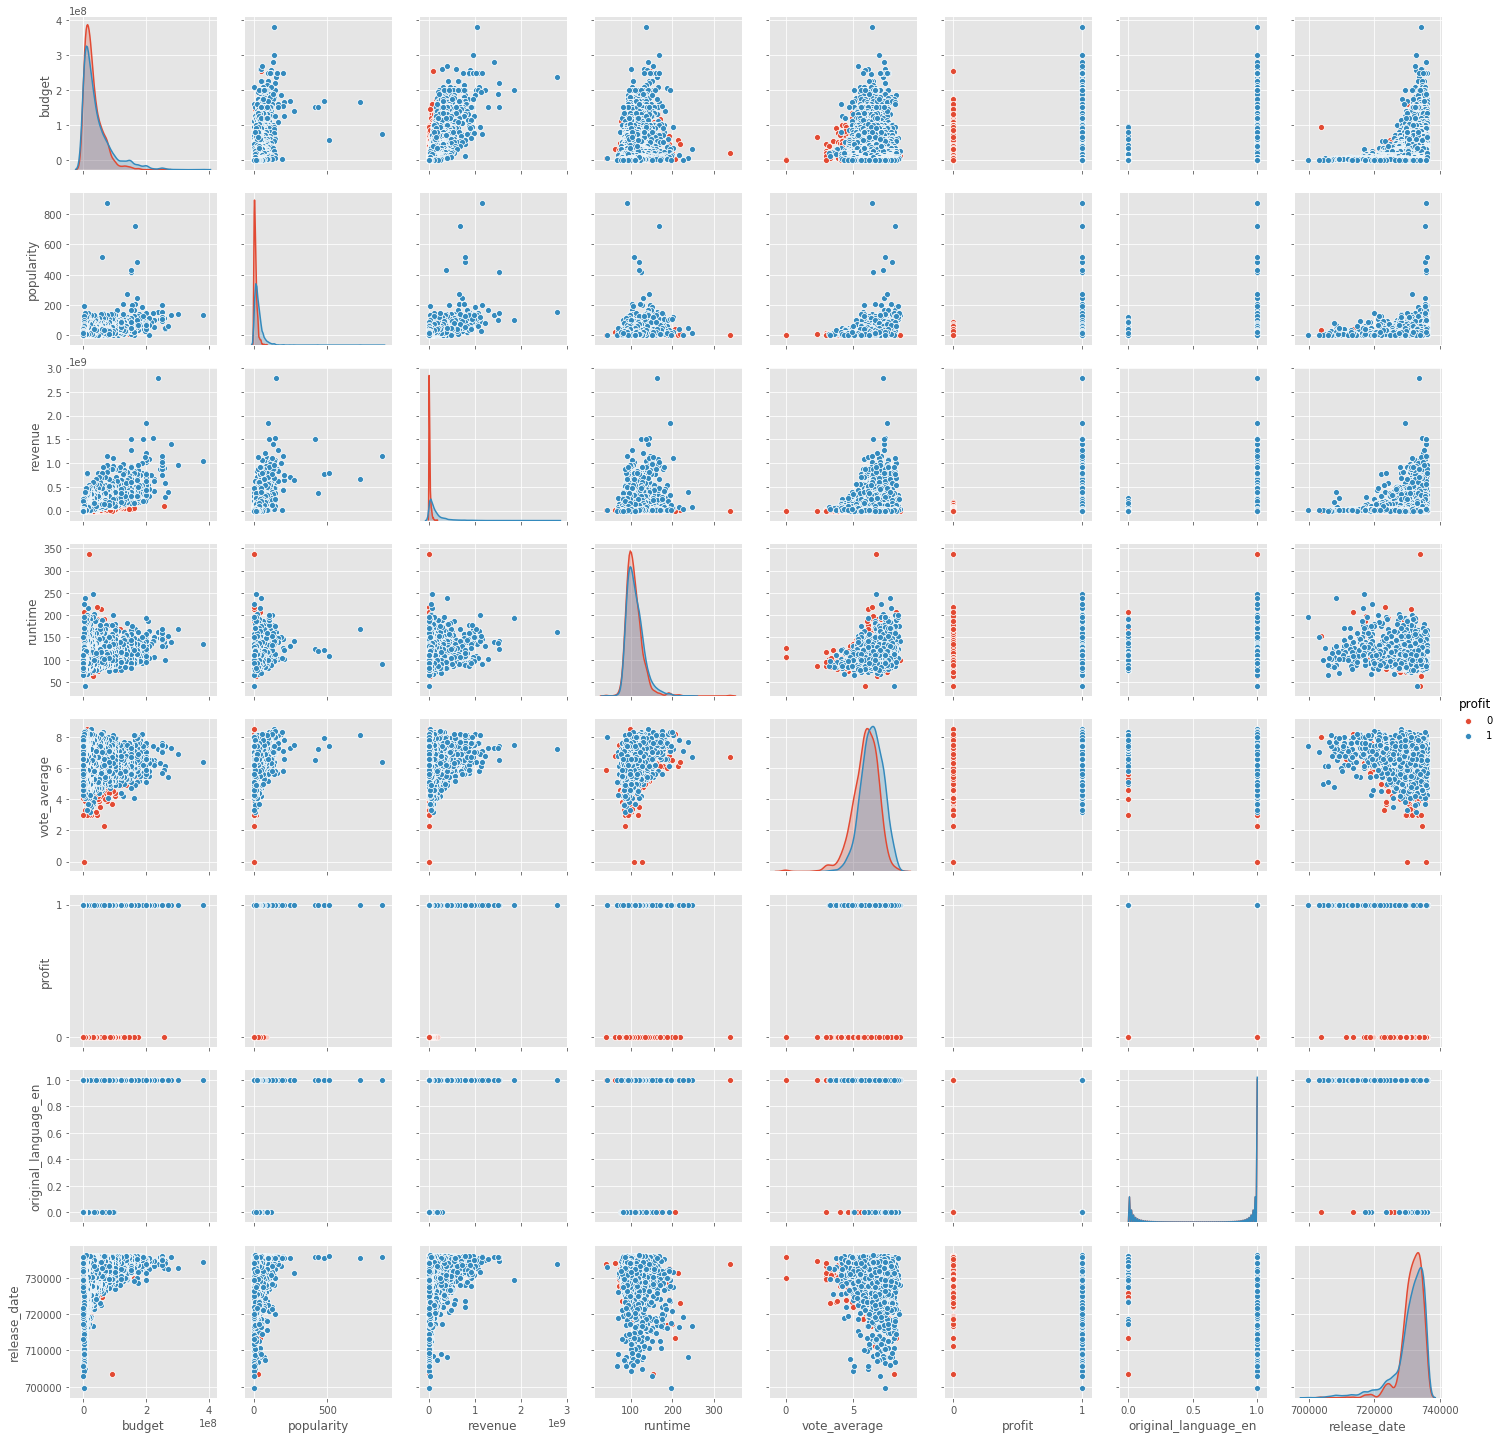

In [0]:
normalized_movies_class_pair = normalized_movies[['budget', 'popularity','revenue','runtime','vote_average', 'profit','original_language_en','release_date']].copy()
sns.pairplot(normalized_movies_class_pair, hue='profit', height = 2.5)

**Initial conclusion:** As we can see here some pair of variables you can explicitly see the different between profit and lost movie but some pairs are overlaped.

Based on the above pairplot, we did not find very obvious clusters which may suggested that the features we involved in the dataset did not have significant correlation with profit values.

Now lets establish the predictive model, here we use logistic regression model and trained *30*% of the data in the new dataset:


First we set "profit" as the target array and set the others as features matrix

In [0]:
X_movies = normalized_movies_class.drop('profit', axis=1)
y_movies = normalized_movies_class['profit']

We would like to evaluate the model on data it has not seen before, and so we will split the data into a training set and a testing set. Use a 30% split for test.

In [0]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X_movies, y_movies, test_size=0.3, random_state=833)

Then, instantiate a logistic regrssion model

In [0]:
from sklearn.linear_model import LogisticRegression 
model = LogisticRegression(solver='liblinear')

Fit model to the training data:

In [0]:
model.fit(Xtrain, ytrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

predict on new (test) data and store the results as `y_model`:

In [0]:
y_model = model.predict(Xtest)

Now that our predictions are ready we can merge them along with the ground truth, our profit, to the test features and visually inspect our model performance:

In [0]:
test = Xtest.join(ytest).reset_index()
test.join(pd.Series(y_model, name='predicted')).head()

,index,budget,popularity,revenue,runtime,vote_average,original_language_en,release_date,is_Action,is_Adventure,...,is_Comedy,is_Romance,is_Horror,is_Mystery,is_History,is_War,is_Music,is_Documentary,profit,predicted
0,1314,38000000,3.426555,17380126,118.0,5.7,1,728929,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2788,12500000,13.349012,23367586,120.0,6.7,1,731203,0,0,...,0,1,0,0,0,0,0,0,1,1
2,1574,30000000,11.409124,63833449,99.0,5.8,1,733155,0,0,...,1,0,0,0,0,0,0,0,1,1
3,2432,17000000,7.864011,7314027,107.0,4.9,1,732374,0,0,...,1,0,0,0,0,0,0,0,0,0
4,3050,10000000,9.525626,8801940,114.0,6.4,1,724574,0,0,...,0,0,1,1,0,0,0,0,0,0


Finally, we can use the ``accuracy_score`` utility to see the fraction of predicted labels that match their true value:

In [0]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, y_model)

0.9989680082559339

**Initial Conclusion:** Our basic model is giving us an accuracy of 66.4%, which might be low interm of accuracy. So we improve our model by bringing new sources of data like original language, release date, and genre and it turns out that our model got improve to accuracy of 99.8%. Moreover, it is a significant figure when comapared to the revenue of the budget of a movie which can be around 260000000. 



# Conclusion
Correlation
-------------
 Overall we have found that the movie genre, the language, the runtime, release date, and the budget are all good indicators of whether a movie will have high revenue. There are also some production companies such as Marvel that consistantly have higher revenue.

Classification
----------------
We were able to build an extremely accurate classification model to determine whether the movie will make a profit or not. The difference in accuracy when genres are added shows the large impact the genre of the movie has on whether a movie will recoup its budget or not.

Regression
-------------
 However, with the regression model we were only able to predict within a mean average error of around $80 million. We would need more data and more information in order to build a better model. Currently we only have around 3000 movies that we are using in our dataset and that is a relatively small dataset. We could have also implemented the seasonality into our model. We could have done this by creating columns for the month and year instead of converting the release date into a unix timestamp
